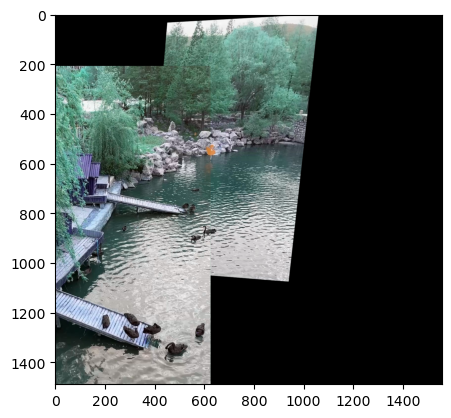

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# def resize(img1,img2):
#     if (img1 is None) or (img2 is None):
#         print("路径问题")
#     else:
#         img1 = cv2.resize(img1,(430,480))
#         img2 = cv2.resize(img2,(430,480))
#         #把数据压到栈中
#         inputs = np.hstack((img1,img2))
#         return img1,img2

    
def get_homo(img1,img2):
    #创建特征转换对象
    sift = cv2.SIFT_create()
    #获取特征点和描述子
    k1,d1 = sift.detectAndCompute(img1,None)
    k2,d2 = sift.detectAndCompute(img2,None)
    #创建特征匹配器
    bf = cv2.BFMatcher()
    #使用描述子进行一对多的描述子匹配
    maches = bf.knnMatch(d1,d2,k=2)
    #筛选有效的特征描述子存入数组中
    verify_matches = []
    for m1,m2 in maches:
        if m1.distance <0.8*m2.distance:
            verify_matches.append(m1)
    #单应性矩阵需要最低四个特征描述子坐标点进行计算，判断数组中是否有足够,这里设为6更加充足
    if len(verify_matches) > 6:
        #存放求取单应性矩阵所需的img1和img2的特征描述子坐标点
        img1_pts = []
        img2_pts = []
        for m in verify_matches:
        #通过使用循环获取img1和img2图像优化后描述子所对应的特征点
            img1_pts.append(k1[m.queryIdx].pt)
            img2_pts.append(k2[m.trainIdx].pt)
        #得到的坐标是[(x1,y1),(x2,y2),....]
        #计算需要的坐标格式：[[x1,y1],[x2,y2],....]所以需要转化
        img1_pts = np.array(img1_pts).reshape(-1,1,2)
        img2_pts = np.array(img2_pts).reshape(-1,1,2)
        #计算单应性矩阵用来优化特征点
        H,mask = cv2.findHomography(img1_pts,img2_pts,cv2.RANSAC,5.0)
        return H
    else:
        print("error")


def stitch_image(img1,img2,H):
    #1、获得每张图片的四个角点
    #2、对图片进行变换，（单应性矩阵使）
    #3、创建大图，将两张图拼接到一起
    #4、将结果输出
    #获取原始图的高、宽
    h1,w1 = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    #获取四个点的坐标，变换数据类型便于计算
    img1_dims = np.float32([[0,0],[0,h1],[h1,w1],[w1,0]]).reshape(-1,1,2)
    img2_dims = np.float32([[0,0],[0,h2],[h2,w2],[w2,0]]).reshape(-1,1,2)
    #获取根据单应性矩阵透视变换后的图像四点坐标
    img1_transform = cv2.perspectiveTransform(img1_dims,H)
    #img2_transform = cv2.perspectiveTransform(img2_dims,H)

    #合并矩阵  获取最大x和最小x，最大y和最小y  根据最大最小计算合并后图像的大小；
    # #计算方式： 最大-最小
    result_dims = np.concatenate((img2_dims,img1_transform),axis = 0)

    #使用min获取横向最小坐标值，ravel将二维转换为一维，强转为int型，
    # 最小-0.5，最大+0.5防止四舍五入造成影响
    [x_min,y_min] = np.int32(result_dims.min(axis=0).ravel()-0.5)
    [x_max,y_max] = np.int32(result_dims.max(axis=0).ravel()+0.5)
    #平移距离
    transform_dist = [-x_min, -y_min]
    #齐次变换矩阵
    transform_arary = np.array([[1,0,transform_dist[0]],
                                [0,1,transform_dist[1]],
                                [0,0,1]])
    #输出图像的尺寸
    ww = x_max-x_min
    hh = y_max-y_min
    #透视变换实现平移
    result_img = cv2.warpPerspective(img1,transform_arary.dot(H),(ww,hh))
    #将img2添加进平移后的图像
    result_img[transform_dist[1]:transform_dist[1]+h2,
                transform_dist[0]:transform_dist[0]+w2] = img2
    return result_img


#读取两张图片
img1 = cv2.imread("f1.jpg")
img2 = cv2.imread("f2.jpg")

# img1,img2=resize(img1,img2)
H = get_homo(img1,img2)
result_img = stitch_image(img1,img2,H)

plt.imshow(result_img)
plt.show()

In [3]:
import cv2

# 打开第一个视频文件
cap1 = cv2.VideoCapture('video1.mp4')

# 获取第一个视频的帧数
frame_count1 = int(cap1.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate2 = int(cap1.get(cv2.CAP_PROP_FPS))
print('第一个视频的帧数为:', frame_count1)
print('第一个视频的帧率为:', frame_rate2)
# 打开第二个视频文件
cap2 = cv2.VideoCapture('video2.mp4')

# 获取第二个视频的帧数
frame_count2 = int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate2 = int(cap2.get(cv2.CAP_PROP_FPS))
print('第二个视频的帧数为:', frame_count2)
print('第二个视频的帧率为:', frame_rate2)
# 释放视频文件
cap1.release()
cap2.release()


第一个视频的帧数为: 1856
第一个视频的帧率为: 28
第二个视频的帧数为: 1870
第二个视频的帧率为: 30


In [4]:
import cv2

cap = cv2.VideoCapture('video2.mp4')
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
cap.release()

print("Video resolution: {} x {}".format(width, height))


Video resolution: 626 x 1280


In [7]:
#修改第二个视频的帧数为1918
import cv2

cap = cv2.VideoCapture('video2.mp4')

fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('output_video.mp4', fourcc, 28, (626, 1280))

for i in range(1856):
    cap.set(cv2.CAP_PROP_POS_FRAMES, i)
    ret, frame = cap.read()
    out.write(frame)
    print(i)
    
cv2.destroyAllWindows()
out.release()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [8]:
# 打开修改后的第二个视频文件
cap2 = cv2.VideoCapture('output_video.mp4')

# 获取第二个视频的帧数
frame_count2 = int(cap2.get(cv2.CAP_PROP_FRAME_COUNT))
frame_rate2 = int(cap2.get(cv2.CAP_PROP_FPS))
print('修改后的第二个视频的帧数为:', frame_count2)
print('修改后的第二个视频的帧率为:', frame_rate2)
# 释放视频文件
cap1.release()
cap2.release()

修改后的第二个视频的帧数为: 1856
修改后的第二个视频的帧率为: 28


In [19]:
# 生成视频文件数组
cap1 = cv2.VideoCapture('video1.mp4')
cap2 = cv2.VideoCapture('output_video.mp4')

video = []
for i in range(1009):
    cap1.set(cv2.CAP_PROP_POS_FRAMES, i)
    cap2.set(cv2.CAP_PROP_POS_FRAMES, i)
    ret1, frame1 = cap1.read()
    ret2, frame2 = cap2.read()
    
    H = get_homo(frame1,frame2)
    result_frame = stitch_image(frame1,frame2,H)
    result_frame = result_frame[200:1100, 0:1000]
    print(i)
    video.append(result_frame)

print(np.array(video).shape)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

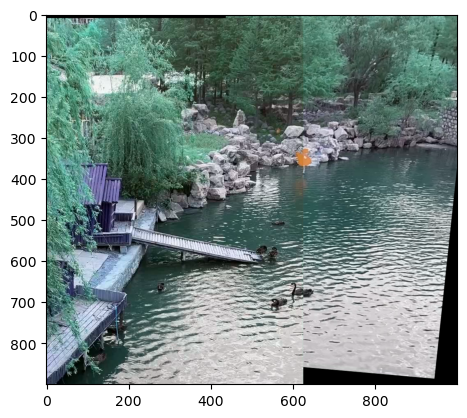

In [20]:
# 输出第一帧图片
plt.imshow(video[1])
plt.show()

In [21]:
# 将所有图片拼接成视频
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter('teminal.mp4', fourcc, 28, (1000, 900))

for img in np.array(video):
    out.write(img)

out.release()
